In [1]:
import os
import cv2
import imutils
import argparse
import numpy as np
from imutils.perspective import four_point_transform
from imutils import contours

(60000, 28, 28)
(60000,)


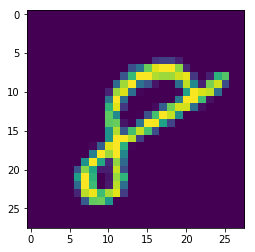

Epoch 1/1
60000/60000 [==============================] - 20s 326us/step - loss: 0.2220 - acc: 0.9347


In [80]:
def train_model_keras_mnist(retrain=True ):
    import tensorflow as tf
    
    mnist = tf.keras.datasets.mnist
    MODEL_NAME = 'keras-mnist-model.h5'
    #DATA_DIRECTORY = 'c:\\repositories\\pycaptcha\\train\\'
    #DATA_DIRECTORY = 'c:\\repositories\\data-analysis-notebooks\\sudoku\\data\\own\\digits-v1'
    DATA_DIRECTORY = 'c:\\repositories\\data-analysis-notebooks\\sudoku\\data\\own\\digits-v2'

    if not os.path.exists(MODEL_NAME) or retrain:
        
        # mnist 
        (x_train, y_train),(x_test, y_test) = mnist.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0
        print(x_train.shape)
        print(y_train.shape)

#         # own dataset
#         x_train, y_train = load_data(DATA_DIRECTORY)
#         x_train = np.array(x_train)
#         y_train = np.array(y_train)
#         print(x_train.shape)
        
        import matplotlib.pyplot as plt
        plt.imshow(x_train[len(x_train)-1])    
        plt.show()

        model = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(512, activation=tf.nn.relu),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        ])

        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        model.fit(x_train, y_train, epochs=1)
        tf.keras.models.save_model(model, MODEL_NAME)
    else:
        model = tf.keras.models.load_model(MODEL_NAME)

    return model

ml_model = train_model_keras_mnist()

In [50]:
def load_data(data_directory):
    ''' Load images from the given repository'''

    directories = [d for d in os.listdir(data_directory)
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels, images = [], []
    for d in directories:

        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f)
                      for f in os.listdir(label_directory)
                      if f.endswith(".png")]

        padding = 1
        for f in file_names:
            _image = cv2.imread(f)
            _image_gray = cv2.cvtColor(_image, cv2.COLOR_BGR2GRAY)
            _image_gray = cv2.threshold(_image_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

            # image must be processed in the save way as the one from captcha
            _ref_cnts = cv2.findContours(_image_gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            _ref_cnts = _ref_cnts[0] if imutils.is_cv2() else _ref_cnts[1]
            _ref_cnts = contours.sort_contours(_ref_cnts, method="left-to-right")[0]
            (x, y, w, h) = cv2.boundingRect(_ref_cnts[0])
            _croped = _image_gray[y-padding:y+h+padding, x-padding:x+w+padding]
            _croped = cv2.resize(_croped, (30, 30))

            images.append(_croped)
            labels.append(int(d))

    return images, labels

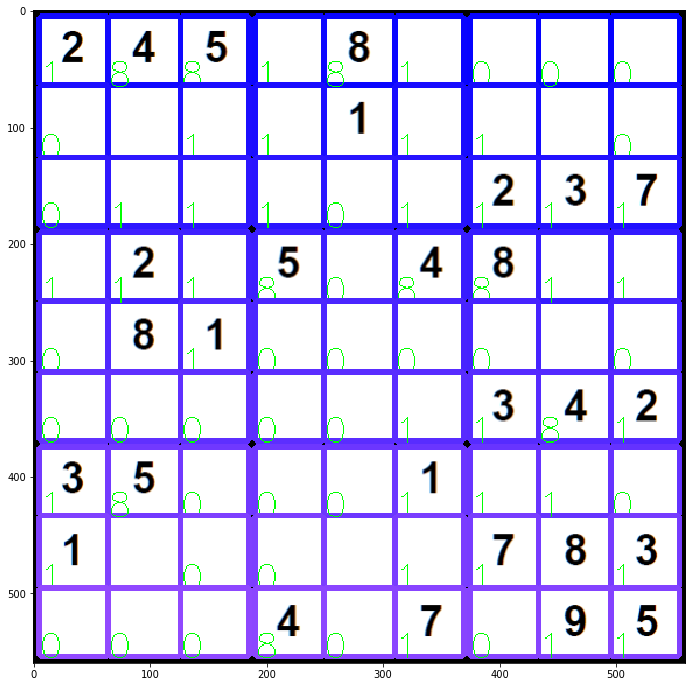

In [77]:
def sudoku_matrix(image_path, ml_model):
    ''' Get matrix of sudoku '''

    # load the image, convert it to grayscale, blur it slightly, then find edges
    image = cv2.imread(image_path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)

    # find contours in the edge map, then initialize the contour that corresponds to the document
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    docCnt = None

    # ensure that at least one contour was found
    if len(cnts) > 0:

        # sort the contours according to their size in descending order
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

        # loop over the sorted contours
        for c in cnts:
            # approximate the contour
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)

            # if our approximated contour has four points, then we can assume we have found the paper
            if len(approx) == 4:
                docCnt = approx
                break

    # apply a four point perspective transform to both the
    # original image and grayscale image to obtain a top-down
    # birds eye view of the paper
    paper = four_point_transform(image, docCnt.reshape(4, 2))
    warped = four_point_transform(gray, docCnt.reshape(4, 2))

    paper = cv2.resize(paper, (560, 560), 0, 0, interpolation = cv2.INTER_CUBIC)
    warped = cv2.resize(warped, (560, 560), 0, 0, interpolation = cv2.INTER_CUBIC)

    #cv2.imshow("SimpleImageShower-paper", paper)
    cv2.imshow("SimpleImageShower-warped", warped)

    # apply Otsu's thresholding method to binarize the warped piece of paper
    thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find contours in the thresholded image, then initialize the list of contours that correspond to questions
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    counter = 0
    cnts_srt = contours.sort_contours(cnts[1], method="top-to-bottom")[0]
    
    # simple check of images
    import matplotlib.pyplot as plt
    plt.figure(figsize = (20,12))
    
    padding = 1
    for index, cnt in enumerate(cnts_srt):

        area = cv2.contourArea(cnt)
        area_coeff = (thresh.shape[0] * thresh.shape[1]) / area
        #print (area, area_coeff)

        #if 3400.0 <= area and area <= 3900.0: # pure area based
        if 84.0 <= area_coeff and area_coeff <= 91.0:

            counter += 1
            color = [2*counter, counter, 255]
            cv2.drawContours(paper, [cnt], -1, color, 3)

            [x, y, w, h] = cv2.boundingRect(cnt)
            _cropped = thresh[y+padding:y+h-padding,x+padding:x+w-padding]
            _cropped = cv2.resize(_cropped, (30, 30))
            #_cropped = cv2.cvtColor(_cropped, cv2.COLOR_BGR2GRAY)
            #_cropped = cv2.threshold(_cropped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            cv2.imwrite('data/{}.png'.format(str(counter).zfill(2)), _cropped)
            
#             plt.imshow(_cropped)    
#             plt.show()

            _digit = '0'
            sum_colors = sum(np.array(_cropped).reshape(30 * 30))
            if sum_colors != 0:
                _digit = str(recognize_digit(_cropped, ml_model))

            # marking image with predicted digits
            cv2.putText(paper, _digit, (x,y+h), 0, 1, (0,255,0))
#         else:
#             print (index, counter)
    
    plt.imshow(paper)    
    plt.show()
    
#     cv2.imshow("SimpleImageShower-newImage", paper)
#     cv2.waitKey(0)

def recognize_digit(image_flatt, ml_model):
    from numpy import newaxis
    #print(ml_model.input_shape)
    #print(image_flatt.shape)
    image_flatt = image_flatt[newaxis,:,:]
    predicted = ml_model.predict_classes(image_flatt, batch_size=1, verbose=0)   
    return predicted[0]

sudoku_matrix("images/sudoku-image-01.png", ml_model)